In [1]:
import random, re, csv
import numpy as np
import math
from simdata import *
# for pre-processing data
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale

# for kmeans
from scipy import stats
from sklearn.cluster import KMeans
# for svm
from sklearn import metrics,svm
#for evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
# for visulization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [79]:
"""
#==============================================
# make synthic data and csv file
#==============================================
sample_num=1000
d_ratio=0.5
dsample_num=math.ceil(sample_num*d_ratio)
ndsample_num=sample_num-dsample_num

#make syn_bhdata
#depressive:  OR:[0.6,0,9], CR:[0.4,1.0], IR:[0.5,0.7], RR:[0.4,0.6]
#no_depessive: OR:[0.3,0.5], CR:[0.6,1.0], IR:[0.1,0.3], RR:[0.1,0.3]
bhf_range={'or':[6,10,3,6],"cr":[4,11,6,11],"ir":[5,8,1,4],"rr":[4,7,1,4]}

syn_bhdata=make_syn_bhdata(sample_num,d_ratio,bhf_range)

syn_bhf=syn_bhdata["syn_bhf"]
syn_prel=syn_bhdata["syn_pre_bhl"]

#make syn_nbhf
nbhf_num=10
syn_nbhf=make_syn_nbhf(nbhf_num,sample_num)

#make syndata
syn_f=np.insert(syn_nbhf,[0],syn_bhf,axis=1)
syndata=np.insert(syn_prel.reshape(1000,1),[0],syn_f,axis=1)

#make syndata.csv 
syndata_filedir="../resources/gamedata/syndata.csv"
create_csvfile(syndata,syndata_filedir)
"""

#===============================================================
# Get data from csv file: syndata_ipld.csv, or , syndata.csv
# *mixdata: [[interdata,biodata,prelabel],...,[]]
#===============================================================

#syndata_ipld_filedir='../resources/gamedata/syndata_ipld.csv'
#mixdata=np.asarray(get_mldata(syndata_ipld_filedir),dtype=float)
syndata_filedir="../resources/gamedata/syndata.csv"
mixdata=np.asarray(get_mldata(syndata_filedir),dtype=float)

#==============================================
# Get mixdata's features_nd/labels 
#==============================================
mixdata_feature = mixdata[:,0:mixdata[0].shape[0]-1]
mixdata_scaler = StandardScaler()
mixdata_feature_ss = mixdata_scaler.fit_transform(mixdata_feature)


mixdata_prelabel = mixdata[:,mixdata[0].shape[0]-1]



#-----------------------------------------------------
# aim: tranformed new data to normal distribution followed by old data
# in: new_data 1*n, 
#     olddata_scaler: data scaler
# out: transformed data
#-----------------------------------------------------
def trans_data(new_data,olddata_scaler):
    transformed_data=olddata_scaler.transform(new_data.reshape(1, -1))
    return transformed_data

#-------------------------------------------------------------
# aim: evaluation the analysers
#      1. clf_cv: accuracies of cross validation on classifier
#      2. clf_acc: accuracy of classifier
#      3. clu_sim: similarity of cluster result and true leables
#-------------------------------------------------------------
def clf_cv(clfer,clf_train_f,clf_train_l,cv_num):
    cv_svm=cross_val_score(clfer,clf_train_f,clf_train_l,cv=cv_num)
    #print("cv acc: %0.2f (+/- %0.2f)" % (cv_svm.mean(), cv_svm.std() * 2))
    return cv_svm

def clf_acc(clfer,clf_test_f,clf_test_l):
    clf_result=clfer.predict(clf_test_f)
    acc_svm=accuracy_score(clf_result,clf_test_l)
    #print("acc_svm: ",acc_svm)
    return acc_svm
    
def clu_sim(cluer,clu_test_f,clu_test_l):
    clu_result=cluer.predict(clu_test_f)
    clu_sim=metrics.adjusted_rand_score(clu_result,clu_test_l)
    #print("similarity_km: ",metrics.adjusted_rand_score(clu_result,clu_test_l))
    return clu_sim
    
#---------------------------------------------------------------------------------------------------------------
# aim: build km cluster, svm classifier and clf_data from data
# in: bhdata,nbhdata;
#     group_num(number of k-means centers)
# out: dict={"cluer":cluster_km,"clfer":classifier_svm,"clf_data":train/test data for building classifier}
#----------------------------------------------------------------------------------------------------------------
def build_analysers(bhf,nbhf,group_num,test_ratio):
    #Cluster from kmeans
    cluster_km = KMeans(n_clusters=group_num, random_state=0).fit(bhf)
    #Classifier from SVM
    cluster_result=cluster_km.labels_
    clf_train_feature,\
    clf_test_feature,\
    clf_train_label,\
    clf_test_label = train_test_split(nbhf,cluster_result, test_size=test_ratio)
    # build classifier
    classifier_svm=svm.SVC(C=1).fit(clf_train_feature,clf_train_label)
    return {"cluer":cluster_km,\
            "clfer":classifier_svm,\
            "clf_data":[clf_train_feature,\
                        clf_train_label,\
                        clf_test_feature,\
                        clf_test_label]}

In [80]:
#=========================================
# Build processors from mixdata
#=========================================
"""cluer_ori=KMeans(n_clusters=2, random_state=0).fit(mixdata_feature_ss[:,0:4])
clu_result=cluer_ori.labels_

#make train/test features and labels
mixdata_train_feature,\
mixdata_test_feature,\
mixdata_train_label,\
mixdata_test_label = train_test_split(mixdata_feature_ss,clu_result, test_size=.6)

# build all analysers


clf_train_label=cluer_ori.predict(mixdata_train_feature[:,0:4])
clf_test_label=cluer_ori.predict(mixdata_test_feature[:,0:4])

clfer_ori=svm.SVC(C=1).fit(mixdata_train_feature[:,5:],mixdata_train_label)


# evaluate the analysers
print("clu_sim",clu_sim(cluer_ori,mixdata_test_feature[:,0:4],mixdata_test_label))
print("clf_acc",clf_acc(clfer_ori,mixdata_test_feature[:,5:],clf_test_label))
clf_cv_1=clf_cv(clfer_ori,mixdata_train_feature[:,5:],mixdata_train_label,3) 
print("clf_cv",clf_cv_1.mean(), clf_cv_1.std() * 2)"""

clu_sim 1.0
clf_acc 0.986666666667
clf_cv 0.997493734336 0.00708878978633


In [93]:
#=========================================
# Build processors from mixdata
#=========================================
group_num=2
test_ratio=0.1
mixdata_bhf=mixdata_feature_ss[:,0:4]
mixdata_nbhf=mixdata_feature_ss[:,5:]

mixdata_analysers=build_analysers(mixdata_bhf,mixdata_nbhf,group_num,test_ratio)

cluer_mix=mixdata_analysers["cluer"]
clfer_mix=mixdata_analysers["clfer"]
clf_data=mixdata_analysers["clf_data"]

# evaluate the analysers
clu_sim(cluer_mix,mixdata_feature_ss[:,0:4],mixdata_prelabel)
clf_acc(clfer_mix,mixdata_nbhf,mixdata_prelabel)
clf_cv(clfer_mix,mixdata_nbhf,mixdata_prelabel,3)

array([ 0.52694611,  1.        ,  0.53012048])

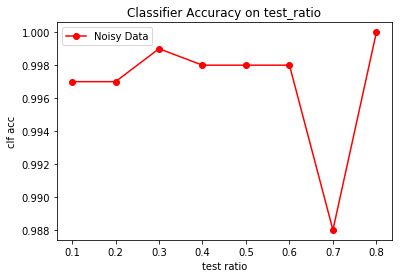

In [94]:
list_test_ratio=np.arange(0.1,0.9,0.1)
list_clf_acc=np.array([])
for i in list_test_ratio:
    #print(i)
    mixdata_analysers=build_analysers(mixdata_bhf,mixdata_nbhf,group_num,i)
    clfer_mix=mixdata_analysers["clfer"]
    list_clf_acc=np.append(list_clf_acc,clf_acc(clfer_mix,mixdata_nbhf,mixdata_prelabel))

plt.plot(list_test_ratio,list_clf_acc,'ro-',label='Noisy Data')
#plt.plot(rawdata,'bo-',label='Raw Data')
plt.legend() # 展示图例
plt.xlabel('test ratio') # 给 x 轴添加标签
plt.ylabel('clf acc') # 给 y 轴添加标签
plt.title('Classifier Accuracy on test_ratio') # 添加图形标题
plt.show()

In [5]:
#==========================================================
# Make uniform noises
#==========================================================
#depressive:  OR:[0.6,0,9], CR:[0.4,1.0], IR:[0.5,0.7], RR:[0.4,0.6]
#no_depessive: OR:[0.3,0.5], CR:[0.6,1.0], IR:[0.1,0.3], RR:[0.1,0.3]

# make uniform noise(int) for bhf


"""
nsample_num=math.ceil(sample_num*noise_level)
uni_noise_bhf=np.random.randint(0,11,nsample_num).reshape(nsample_num,1)
for i in range(3):
    noise_v=np.random.randint(0,11,nsample_num).reshape(nsample_num,1)
    uni_noise_bhf = np.insert(uni_noise_bhf,[1],noise_v,axis=1)
    
# build uniform noised bhf
data_scaler = StandardScaler()
uni_noise_bhf=data_scaler.fit_transform(uni_noise_bhf)

# build uni_noise_mixdata: replace mixdata's bhf with uni_noised_bhf 
nsample_indx=np.random.randint(0,sample_num,nsample_num)
uni_noise_mixdata=mixdata
for i in range(nsample_indx.shape[0]):
    n_indx=nsample_indx[i]
    uni_noise_mixdata[n_indx,0:4]=uni_noise_bhf[i]"""
#--------------------------------------------------
# aim: add uniform noise to bhf of mixdata_feature
# in: noise_level, eg.0.4 ;
#     oridata_feature
# out: uni_noise_feature 
#--------------------------------------------------
def add_unin2bhf(noise_level,oridata_feature):
    sample_num=oridata_feature.shape[0]
    nsample_num=math.ceil(sample_num*noise_level)
    uni_noise_bhf=np.random.randint(0,11,nsample_num).reshape(nsample_num,1)
    for i in range(3):
        noise_v=np.random.randint(0,11,nsample_num).reshape(nsample_num,1)
        uni_noise_bhf = np.insert(uni_noise_bhf,[1],noise_v,axis=1)
    # build uni_noise_mixdata: replace mixdata's bhf with uni_noised_bhf 
    nsample_indx=np.random.randint(0,sample_num,nsample_num)
    uni_noise_feature=oridata_feature
    for i in range(nsample_indx.shape[0]):
        n_indx=nsample_indx[i]
        uni_noise_feature[n_indx,0:4]=uni_noise_bhf[i]
    return uni_noise_feature

sample_num=mixdata_feature.shape[0]
noise_level=0.4
uni_noise_feature=add_unin2bhf(noise_level,mixdata_feature)

data_scaler = StandardScaler()
uni_noise_feature_ss=data_scaler.fit_transform(uni_noise_feature)



[ True  True  True  True  True  True  True  True  True]


In [ ]:
#=====================================================
# Build processors from uniform noised mixdata
#=====================================================

#make train/test features and labels
undata_train_feature,\
undata_test_feature,\
undata_train_label,\
undata_test_label = train_test_split(uni_noise_mixdata,mixdata_prelabel, test_size=.2)


# build all analysers
cluer_unin=KMeans(n_clusters=2, random_state=0).fit(undata_train_feature[:,0:4])

un_clf_train_label=cluer_ori.predict(undata_train_feature[:,0:4])
un_clf_test_label=cluer_ori.predict(undata_test_feature[:,0:4])

clfer_unin=svm.SVC(C=1).fit(undata_train_feature[:,5:],clf_train_label)

In [ ]:
# evaluate the analysers
clu_sim(cluer_unin,undata_test_feature[:,0:4],undata_test_label)
clf_acc(clfer_unin,undata_test_feature[:,5:],undata_test_label)
clf_cv(clfer_unin,undata_train_feature[:,5:],undata_train_label)

In [ ]:
num_data=np.arange(0,noisydata.size)
plt.plot(num_data,noisydata,'ro-',label='Noisy Data')
plt.plot(rawdata,'bo-',label='Raw Data')
plt.legend() # 展示图例
plt.xlabel('Offer type') # 给 x 轴添加标签
plt.ylabel('Offer Value') # 给 y 轴添加标签
plt.title('Uniform Noise Analysis') # 添加图形标题
plt.show()

In [ ]:
testdata=np.random.randint(0,11,1000).reshape(1000,1)
testdata_nd=(testdata - testdata.mean(axis=0)) / testdata.std(axis=0)

scale_testdata=scale(testdata)

data_stscaler = StandardScaler()



data_stscaler.fit(testdata)
trans_testdata=data_stscaler.fit_transform(testdata)


print("data mean:",np.mean(testdata))
print("data std:",np.std(testdata))

print("scaler mean:",data_stscaler.mean_)
print("scaler std:",np.sqrt(data_stscaler.var_))

print("trans_testdata mean:",np.mean(trans_testdata))
print("trans_testdata std:",np.std(trans_testdata))

print("scale_testdata mean:",np.mean(scale_testdata))
print("scale_testdata std:",np.std(scale_testdata))

print("max,min of data",np.max(testdata),np.min(testdata))
print("max,min of transdata",np.max(trans_testdata),np.min(trans_testdata))
print("max,min of scaledata",np.max(scale_testdata),np.min(scale_testdata))

sigma=np.std(trans_testdata)
mu=np.mean(trans_testdata)

count,bind,ignored=plt.hist(testdata, 20, density=True,color='g')
tcount, tbins, tignored = plt.hist(trans_testdata, 20, density=True,color='y')

ndcount, ndbins, ndignored = plt.hist(testdata_nd, 20, density=True,color='b')

plt.plot(tbins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (tbins - mu)**2 / (2 * sigma**2) ),
        linewidth=2, color='r')
plt.show()